[View in Colaboratory](https://colab.research.google.com/github/NgoDinh/Data-science/blob/master/Deep_learning/keras_scalar_regression.ipynb)

<h1>Scalar regression with keras</h1>

In [0]:
import numpy as np
from keras.datasets import boston_housing
from keras import models
from keras import layers
from keras import backend as K

#prepare data
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [0]:
#build model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [0]:
k = 4
num_val = len(train_data)//k
num_epochs = 100
all_scores = []

In [0]:
#mae: mean absolute error, mse: mean square error
# first approach
for i in range(k):
    print("processing fold #",i)
    val_data = train_data[i*num_val:(i+1)*num_val]
    val_targets = train_targets[i*num_val:(i+1)*num_val]
    partical_train_data = np.concatenate([train_data[:i*num_val],train_data[(i+1)*num_val:]], axis=0)
    partical_train_targets = np.concatenate([train_targets[:i*num_val],train_targets[(i+1)*num_val:]], axis=0)
    
    model = build_model()
    model.fit(partical_train_data, partical_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
# Some memory clean-up
K.clear_session()
num_epochs = 500
all_mae_histories = []

#second approach
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val: (i + 1) * num_val]
    val_targets = train_targets[i * num_val: (i + 1) * num_val]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val],
         train_data[(i + 1) * num_val:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val],
         train_targets[(i + 1) * num_val:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


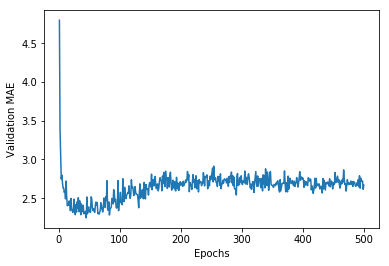

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

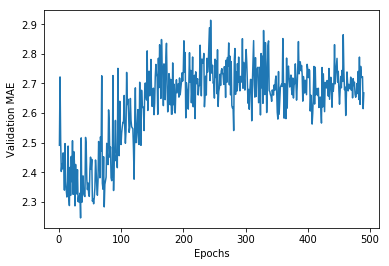

In [0]:
#adjust first ten element
plt.plot(range(1, len(average_mae_history) +1 - 10), average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

$ S_t = ax_t + (1-a)S_{(t-1)}$<br/>
Formula Explanation :

The formula states that the value of the moving average(S) at time t is a mix between the value of raw signal(x) at time t and the previous value of the moving average itself i.e. t-1. The degree of mixing is controlled by the parameter a (value between 0–1).

So, if a = 10%(small), most of the contribution will come from the previous value of the signal. In this case, “smoothing” will be very strong.

if a = 90%(large), most of the contribution will come from the current value of the signal. In this case, “smoothing” will be minimum.

So for a better understanding, we will consider an example of “temperature variation on the weekdays of a week” data.

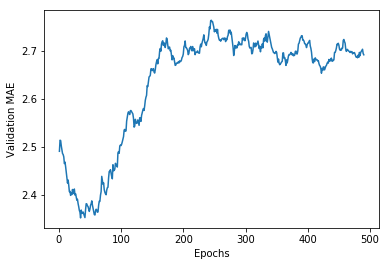

In [0]:
#smooth data before plot it
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [0]:
#final model
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 487us/step


In [0]:
print("Average score with 500 epochs and 4 iteration: %f\nScore with 80 epochs: %f"%(np.mean(all_scores), test_mae_score))

Average score with 500 epochs and 4 iteration: 2.366996
Score with 80 epochs: 2.684000


<h1>Wrapping up</h1>

Here's what you should take away from this example:
-Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.</br>
-Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).</br>
-When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.</br>
-When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.</br>
-When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.